In [1]:
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

import core.assignment_models as Models
from core.DataLoader import DataPreprocessor, DataConfig, LoadConfig
import core
import numpy as np
from importlib import reload
import keras
import matplotlib.pyplot as plt

MAX_JETS = 6

PLOTS_DIR = f"plots/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

load_config = LoadConfig(
    jet_features=[
        "ordered_jet_pt",
        "ordered_jet_eta",
        "ordered_jet_phi",
        "ordered_jet_e",
        "ordered_jet_b_tag",
    ],
    lepton_features=["lep_pt", "lep_eta", "lep_phi", "lep_e"],
    jet_truth_label="ordered_event_jet_truth_idx",
    lepton_truth_label="event_lepton_truth_idx",
    met_features=["met_met_NOSYS", "met_phi_NOSYS"],
    max_leptons=2,
    max_jets=MAX_JETS,
    non_training_features=["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"],
    event_weight="weight_mc_NOSYS",
)

DataProcessor = DataPreprocessor(load_config)
DataProcessor.load_data(
    "../../data/full_training.root", "reco", max_events=1000000
)
# DataProcessor.normalise_data()
X_train, y_train, X_val, y_val = DataProcessor.split_data(
    test_size=0.1, random_state=42
)

data_config = load_config.to_data_config()

Removed 2998 events with negative weights


In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name="Transformer")

TransformerMatcher.build_model(
    num_heads=8,
    hidden_dim=64,
    num_layers=6,
    dropout_rate=0.1,
    input_as_four_vector=True,
)

TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss = core.utils.AssignmentLoss(lambda_excl=0), optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), metrics=[core.utils.AssignmentAccuracy()]
)
TransformerMatcher.model.summary()
#TransformerMatcher.load_model("Transformer_Assignment.keras")

Model: "FeatureConcatTransformerModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ met_inputs          │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_transform │ (None, 1, 2)      │          0 │ met_inputs[0][0]  │
│ (InputMetPhiLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_transform │ (None, 2, 4)      │          0 │ lep_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 6, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_normaliz… │ (None, 1, 2)      │          5 │ met_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_normaliz… │ (None, 2, 4)      │          9 │ lep_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_transform │ (None, 6, 5)      │          0 │ jet_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ met_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ lep_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_normaliz… │ (None, 6, 5)      │         11 │ jet_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 6, 2)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 6, 8)      │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 15)     │          0 │ jet_input_normal… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 6, 64)     │      3,919 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 6, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ jet_embedding[0]… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 206,216 (805.54 KB)

 Trainable params: 206,191 (805.43 KB)

 Non-trainable params: 25 (112.00 B)

In [3]:
TransformerMatcher.train_model(epochs=1,
                                X_train=X_train,
                                y_train=y_train,
                                sample_weights=core.utils.compute_sample_weights(X_train, y_train),
                                batch_size=5000,
                                callbacks = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, mode ="min"))

 26/144 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - assignment_accuracy: 0.1472 - loss: 0.7751

KeyboardInterrupt: 

In [ ]:
TransformerMatcher.save_model("Transformer_Assignment.keras")

In [ ]:
reload(core)
ml_eval = core.reconstruction.MLEvaluator(TransformerMatcher, X_val, y_val)

In [ ]:
ml_eval.plot_feature_importance(num_repeats=1)
ml_eval.plot_training_history()


In [ ]:
TransformerMatcher.export_to_onnx("Transformer_Assignment.onnx")

In [ ]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load("Transformer_Assignment.onnx")
onnx.checker.check_model(onnx_model)
ort_session = ort.InferenceSession("Transformer_Assignment.onnx")
flatted_inputs = np.concatenate([X_val['jet'].reshape(X_val['jet'].shape[0], -1), X_val['lepton'].reshape(X_val['lepton'].shape[0], -1), X_val['met'].reshape(X_val["met"].shape[0],-1)], axis=-1).astype(np.float32)

In [ ]:
outputs = ort_session.run(None, {"flat_input": flatted_inputs})[0]

In [ ]:
import onnx

model = onnx.load("Transformer_Assignment.onnx")
print([inp.name for inp in model.graph.input])
print([out.name for out in model.graph.output])

In [4]:
import core.assignment_models as BaselineMethods
import core.reconstruction.Evaluation as Evaluation
reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(data_config, name=r"$\Delta R$-Assignment")
invariant_mass_assigner = BaselineMethods.LeptonJetMassAssigner(data_config, name = r"$m(\ell, j)$-Assignment")

evaluator = Evaluation.ReconstructionEvaluator([delta_r_assigner,invariant_mass_assigner,TransformerMatcher], X_val, y_val)


Computing binned accuracy for truth_ttbar_mass...


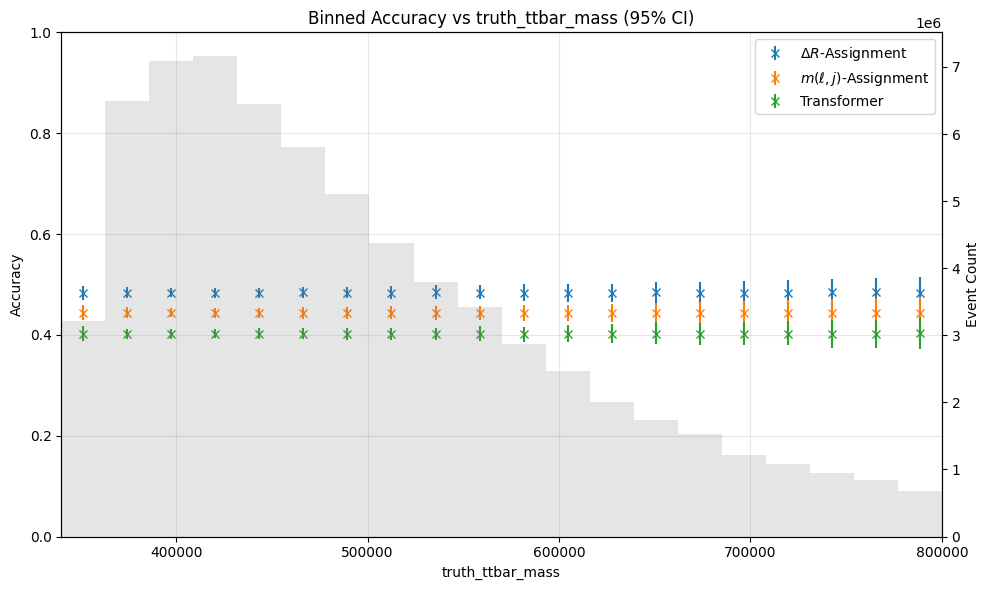

In [5]:
evaluator.plot_binned_accuracy(feature_data_type='non_training', feature_name='truth_ttbar_mass', xlims = (340e3,800e3))

In [ ]:
evaluator.plot_confusion_matrices()

In [ ]:
evaluator.plot_all_accuracies()